In [ ]:
# TODO: change from mounting drive to local files
# TODO: add tests

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/gsoc-evaluation-task/

/content/drive/MyDrive/gsoc-evaluation-task


In [3]:
%ls

data/  model/  README.md


In [51]:
%pip install -q seaborn_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.1 MB/s eta 0:00:00


In [52]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.typing import NDArray
import seaborn as sns
import seaborn_image as isns
from sklearn.metrics import roc_curve, auc

In [5]:
data_path = Path('data')
model_path = Path('model')

In [6]:
images = np.load(data_path / 'images.npy')
labels = np.load(data_path / 'labels.npy')

In [35]:
# TODO: can we keep generic? what if it's a string?
def labels_description(data: NDArray[np.generic]) -> None:
  df = pd.DataFrame(data)
  print(df.describe())
  print(df.info())

def slice_description(data: NDArray[np.float64]) -> None:
  slice = data[0, :, :].reshape(256,)
  df = pd.DataFrame(slice)
  print(df.describe())
  print(df.info())

In [36]:
slice_description(images)

                0
count  256.000000
mean     0.955877
std      0.908362
min      0.007223
25%      0.306411
50%      0.691741
75%      1.343379
max      6.263326
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       256 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


In [27]:
df = pd.DataFrame(images[0, :, :])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       16 non-null     float64
 1   1       16 non-null     float64
 2   2       16 non-null     float64
 3   3       16 non-null     float64
 4   4       16 non-null     float64
 5   5       16 non-null     float64
 6   6       16 non-null     float64
 7   7       16 non-null     float64
 8   8       16 non-null     float64
 9   9       16 non-null     float64
 10  10      16 non-null     float64
 11  11      16 non-null     float64
 12  12      16 non-null     float64
 13  13      16 non-null     float64
 14  14      16 non-null     float64
 15  15      16 non-null     float64
dtypes: float64(16)
memory usage: 2.1 KB
None


In [68]:
# TODO: check the type of pixels
def print_random_image(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  plt.imshow(images[index])
  plt.title(f'Label: {labels[index]}')
  plt.show()

def print_image_distribution(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  ax = isns.imghist(images[index])
  plt.title(f'Index: {index}, Label: {labels[index]}')

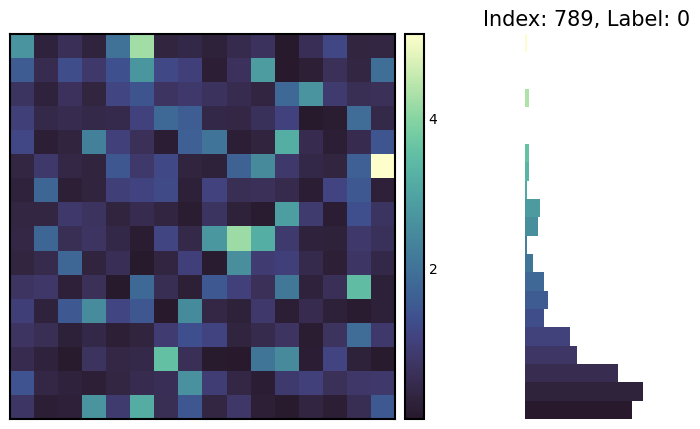

In [69]:
# TODO: histogram of pixel intensities using seaborn (or alternatives)
print_image_distribution(images, labels)

In [85]:
model = tf.saved_model.load(model_path)

AttributeError: '_UserObject' object has no attribute 'summary'

In [88]:
#keras_model = tf.keras.models.load_model('model')
keras_model = tf.keras.layers.TFSMLayer(model_path, call_endpoint = 'serving_default')

In [89]:
print(keras_model.summary())

AttributeError: 'TFSMLayer' object has no attribute 'summary'

In [75]:
infer = model.signatures['serving_default']

In [81]:
print(images[0, :, :][None, :].shape)

(1, 16, 16)


In [94]:
input_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

In [113]:
output = infer(input_tensor)
output = output['lambda'].numpy()

In [117]:
print(output[:10], type(output[0]))

[244.7044  246.41003 266.45758 287.88647 289.0215  273.17194 278.84222
 281.30765 251.8764  282.83258] <class 'numpy.float32'>


In [114]:
min_score = np.min(output)
max_score = np.max(output)

In [118]:
output[0]-min_score

np.float32(34.27954)

In [122]:
normalized_output = []
for score in output:
  normalized_output.append((score - min_score)/(max_score-min_score))

In [124]:
fpr, tpr, thresholds = roc_curve(labels, normalized_output)

In [125]:
roc_auc = auc(fpr, tpr)

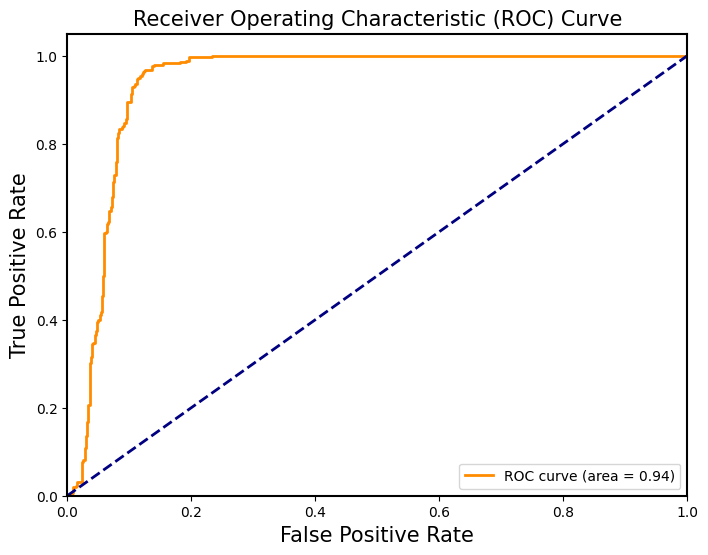

In [126]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line (random classifier)

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show plot
plt.show()